Here we use three classifiers to try to determine the “trendiness” of a single time series, in this case SPY. Models are trained on nonsequential rows but those rows do have time-related items. We use day of week integer, month of year integer, volume, daily change in volume, daily change in OHLC based on previous close, 1-3 lagged covariance, percentage of max Shannon entropy based on a 22-day lookback. The target is an [0,8] integer classification based on three, five, and ten future consecutive days of positive or negative returns, zero is none of the above. The purpose here is telemetry—dials and gauges for the trend state. At the end we fashion a crude backtest but that work is pretty much a lark. bscottwyoming@gmail.com

In [106]:
# imports 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import tensorflow as tf

In [107]:
# load data
data_loc = 'C:/Users/bscot/OneDrive/Documents/Python Trend'
data = pd.read_csv(os.path.join(data_loc, 'data_SPY.csv'))
# partition
X_load = data.drop(columns =['Date','Trend Classification']) 
y = data[['Date','Trend Classification']] 

# scale X
X_transform = StandardScaler().fit(X_load)
X_train_scaled = X_transform.transform(X_load)
X = pd.DataFrame(X_train_scaled, columns = X_drop_date.columns)

# split data for holdout method
# date is still associated
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

print('X_train dataframe is: ',X_train.shape)
print('X_test dataframe is: ',X_test.shape)
print('y_train dataframe is: ',y_train.shape)
print('y_test dataframe is: ',y_test.shape)

X_train dataframe is:  (4223, 13)
X_test dataframe is:  (1056, 13)
y_train dataframe is:  (4223, 2)
y_test dataframe is:  (1056, 2)


In [108]:
# drop dates
y_exdate = y.drop(columns =['Date']) 
y_train_exdate = y_train.drop(columns =['Date']) 
y_test_exdate = y_test.drop(columns =['Date']) 
print('X_exdate dataframe is: ',y_exdate.shape)
print('y_train_exdate dataframe is: ',y_train_exdate.shape)
print('y_test_exdate dataframe is: ',y_test_exdate.shape)

X_exdate dataframe is:  (5279, 1)
y_train_exdate dataframe is:  (4223, 1)
y_test_exdate dataframe is:  (1056, 1)


In [109]:
# check symmetry of training set 
freq = y_exdate.value_counts()
freq/sum(freq)*100 

Trend Classification
0                       76.188672
2                       11.536276
1                        7.084675
4                        3.807539
3                        1.250237
6                        0.132601
dtype: float64

In [111]:
t0_ = time()
# create logistic pipeline
#
pca = PCA()
#
# regression object
lr = LogisticRegression(random_state=1, solver='lbfgs',multi_class='ovr')
# lr = LogisticRegression()


# Pipeline of two steps
pipeline_lr = Pipeline(steps=[('pca', pca), ('lr', lr)])
# lasso parameter space
parameters_lr = {
    'pca__n_components': [4,8,13],
    'lr__C': np.logspace(-4, 4, 4),
}

# perform 5x2 nested cross validation
optimize_lr = GridSearchCV(pipeline_lr, parameters_lr,scoring='accuracy', cv=2)
# understand features and hyperparams
optimize_lr.fit(X_train,y_train_exdate.values.ravel())
# 
scores_lr = cross_val_score(optimize_lr,X_train, y_train_exdate, scoring='accuracy', cv=5, n_jobs=-1)
#
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_lr),np.std(scores_lr)))
print('Best C:', optimize_lr.best_estimator_.get_params()['lr__C'])
print('Best Number Of Components:', optimize_lr.best_estimator_.get_params()['pca__n_components'])
t0_lr = (time() - t0_)
print("done in %0.3fs" % (t0_lr))

C:\Users\bscot\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CV accuracy: 0.764 +/- 0.000
Best C: 0.0001
Best Number Of Components: 4
done in 3.485s


In [82]:
# output predictions
lr_preds = pd.DataFrame(optimize_lr.predict(X_test))
print(lr_preds.shape)
lr_preds.to_csv (r'C:/Users/bscot/OneDrive/Documents/Python Trend/lr_preds.csv', index = False, header=True)

(1056, 1)


In [112]:
t0_ = time()
# create svc pipeline
#
# pca object
pca = PCA()
# regression object
svc = SVC(kernel='rbf',random_state=1)

# pipeline of three steps
pipeline_svc = Pipeline(steps=[('pca', pca),('svc', svc)])

# svr parameter space
parameters_svc = {
    'pca__n_components': [4,8,13],
    'svc__C': [1.0, 50.0, 100.0],
    'svc__gamma': [0.10, 50.0, 100.0],   
}

# perform 5x2 nested cross validation
optimize_svc = GridSearchCV(pipeline_svc, parameters_svc,scoring='accuracy', cv=2)
# understand features and hyperparams
optimize_svc.fit(X_train, y_train_exdate.values.ravel())
#
scores_svc = cross_val_score(optimize_svc,X_train, y_train_exdate.values.ravel(), scoring='accuracy', cv=5, n_jobs=-1)
#
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_svc),np.std(scores_svc)))
print('Best C:', optimize_svc.best_estimator_.get_params()['svc__C'])
print('Best gamma:', optimize_svc.best_estimator_.get_params()['svc__gamma'])
print('Best Number Of Components:', optimize_svc.best_estimator_.get_params()['pca__n_components'])
t0_svc= (time() - t0_)
print("done in %0.3fs" % (t0_svc))

CV accuracy: 0.764 +/- 0.001
Best C: 1.0
Best gamma: 100.0
Best Number Of Components: 4
done in 90.668s


In [98]:
# output predictions
svc_preds = pd.DataFrame(optimize_svc.predict(X_test))
print(svc_preds.shape)
svc_preds.to_csv (r'C:/Users/bscot/OneDrive/Documents/Python Trend/svc_preds.csv', index = False, header=True)

(1056, 1)


In [113]:
trend_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='sigmoid', 
                          name='fc1', input_shape=(13,)),
    tf.keras.layers.Dense(50, activation = 'sigmoid'),
    tf.keras.layers.Dense(50, activation = 'sigmoid'),
    tf.keras.layers.Dense(7, name='fc2', activation='softmax')])

trend_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 50)                700       
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
fc2 (Dense)                  (None, 7)                 357       
Total params: 6,157
Trainable params: 6,157
Non-trainable params: 0
_________________________________________________________________


In [114]:
trend_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

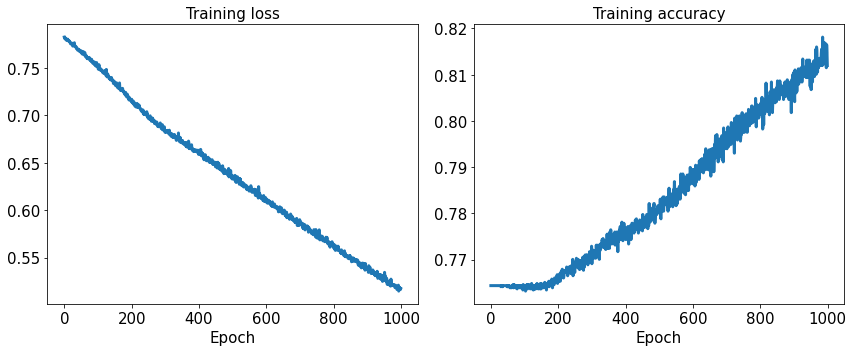

In [116]:
num_epochs = 1000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

history = trend_model.fit(X_train,y_train_exdate, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()

In [117]:
results = trend_model.evaluate(X_test, y_test_exdate, verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))



Test loss: 1.5802   Test Acc.: 0.7292


In [121]:
nn_preds = pd.DataFrame(trend_model.predict(X_test))
print(nn_preds.shape)
print(y_test.shape)
nn_preds.to_csv (r'C:/Users/bscot/OneDrive/Documents/Python Trend/nn_preds.csv', index = False, header=True)
y_test.to_csv (r'C:/Users/bscot/OneDrive/Documents/Python Trend/y_test.csv', index = False, header=True)

(1056, 7)
(1056, 2)


In [76]:
#nn_preds = pd.concat([y_test,y_pred], axis=1)
#print("Size of the dataset (row, col): ", nn_preds.shape)
#print("\nFirst 5 rows\n", nn_preds.head(n=5))
#nn_preds.to_csv (r'C:/Users/bscot/OneDrive/Documents/Python Trend/data_to_predict.csv', index = False, header=True)

The below charts detail our crude backtest using the NN model. Here we deploy our trained model on the withheld test set. We set the following conditions: as shown in the below histogram, not surprisingly the model does not predict a trend state very often so we turn it off after X days of no signal, the default position during the off state is an unlevered long; we do not turn the model on until it is less than or equal to Y% sure the times series is not trending; since we trained the model on a trend state as either mild, medium, or hot we assign a lever to those signals, either 1.0, 1.5, or 2.0 to the long or short side; that is, if the model is on we select the largest signal and its associated lever; today’s return is based on the signal computed two days ago. In the below line chart we show the NAV for a strategy that turns on only when no-trend signal was less than or equal to 55% and we set the no-signal breaker to 10 days. The red line is the strategy NAV. These are reasonable parameters but deploying an array of reasonable parameters does not yields consistent results and requires further research. The vertical bars from the top and bottom indicate long and short signal strength and inspection indicates the model can at least be concurrent. Alas, the success of the below path was cherry picked from an array of what appear to be noisy paths. 

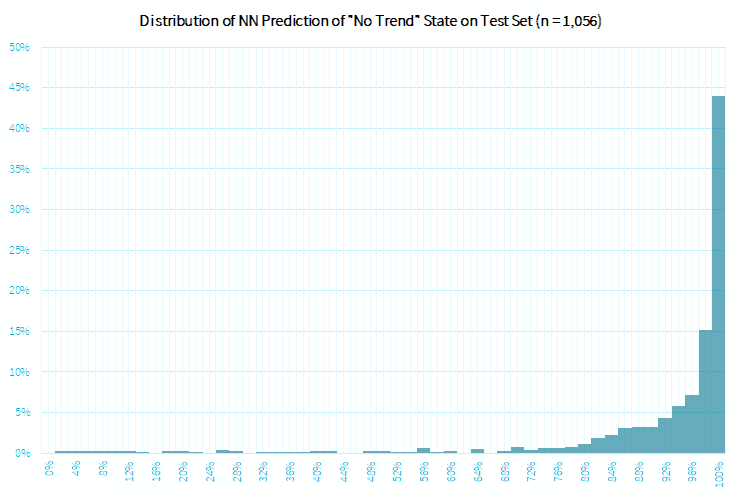

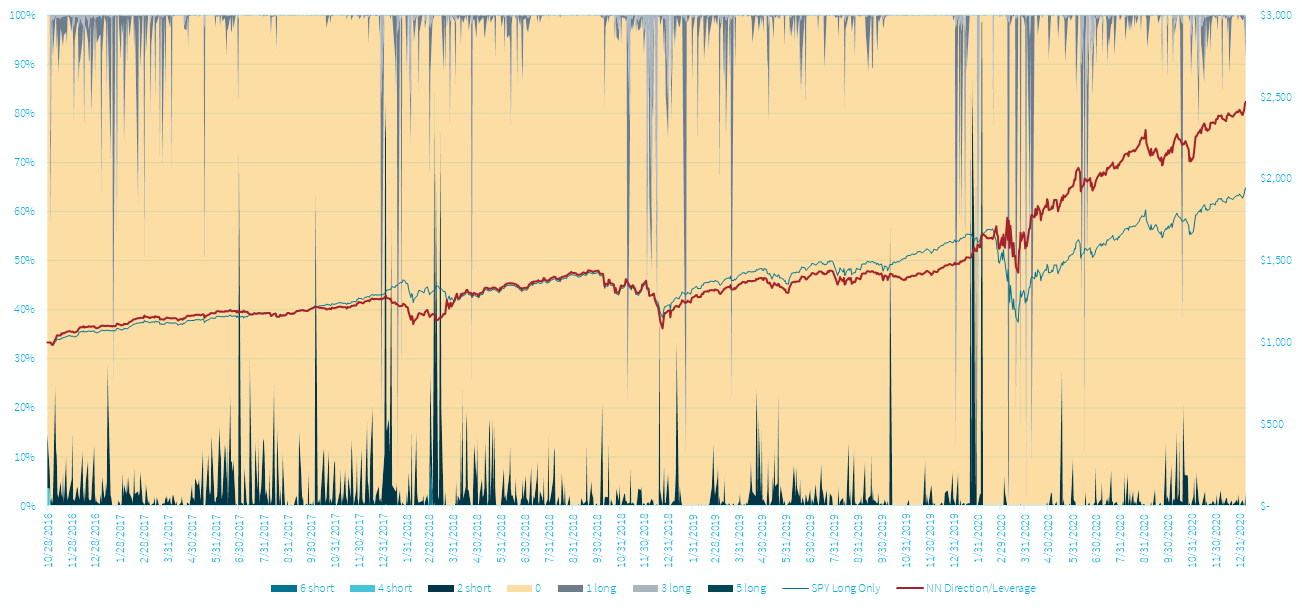